In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from url_parser import parse_url
import numpy as np

client = Client()

In [2]:
client 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36057,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:41437,Total threads: 4
Dashboard: http://127.0.0.1:39335/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:33495,


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()

In [4]:
dat = dd.read_parquet("data/output")

In [5]:
only_us = dat[(dat.Actor1Code == "USA")]
only_china = dat[(dat.Actor1Code == "CHN")]
only_russia = dat[(dat.Actor1Code == "RUS")]

In [6]:
dat.head()

,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import re
import string
from urllib.parse import urlparse

all_features = []
gid_codes = []
var_arr = ["QuadClass", "GoldsteinScale", "AvgTone"]
country_arr = [only_us.head(10000, npartitions=100), 
            only_china.head(10000, npartitions=100), 
            only_russia.head(10000, npartitions=100)]

data_arr = pd.concat(country_arr)
features = data_arr[var_arr]
features.dropna()
    
arr = features.to_records()

for idx, row in enumerate(tqdm(arr)):
    float_row = []
    # we don't want the global Event ID in our feature set
    for item in list(row)[1:]:
        try:
            float_row.append(float(item))
        # we also want to ignore any rows that contain a None
        except:
            continue
    if len(float_row) == len(var_arr):
        all_features.append(float_row)
        gid_codes.append(row[0])

all_features = np.array(all_features)
print(f"Final Shape: {all_features.shape}")

100%|██████████████████████████████████████████| 30000/30000 [00:00<00:00, 327396.09it/s]

Final Shape: (30000, 3)


In [8]:
X = np.array(all_features)
X.shape

(30000, 3)

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## DBSCAN

Running Clustering
Counter({0: 16850, 2: 4696, 1: 2794, 4: 2655, 3: 2490, 5: 504, -1: 11})


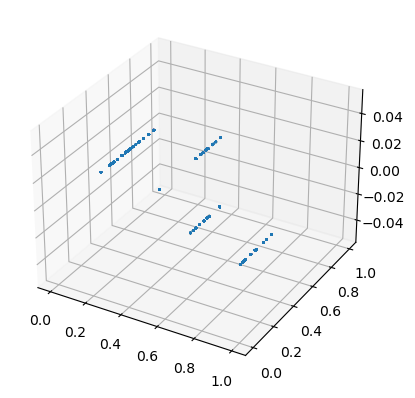

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import KernelPCA
from collections import Counter

print("Running Clustering")
clustering = DBSCAN(eps=0.1, min_samples=20, n_jobs=10).fit(X)
print(Counter(clustering.labels_))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(X[:,0],X[:, 1],X[:, 2])
plt.show()

In [11]:
from pprint import pprint
from collections import defaultdict

def analyze_clusters(X, labels, gid_codes):
    avg_features = defaultdict(lambda: np.zeros(X[0].shape))
    actor1_features = defaultdict(lambda: dict({"USA": 0, "CHN": 0, "RUS": 0}))
    for cluster_id, event_id, features in tqdm(
                    zip(labels, gid_codes, X),
                    total=len(X)):
        curr_event = data_arr.loc[event_id]
        avg_features[cluster_id] += features
        actor1_features[cluster_id][curr_event["Actor1Code"]] += 1


    for cid, feat in avg_features.items():
        avg_features[cid] = avg_features[cid] / len(X)

    max_actor1_features = {}
    for cid, feat in actor1_features.items():
        total_count = sum([count for _, count in feat.items()])
        max_country = max(feat.items(), key=lambda x: x[1])
        max_actor1_features[cid] = (max_country[0], max_country[1]/total_count)

    print("Average Features of a given cluster")
    pprint(dict(avg_features))
    print("\nNumber of events by the actors in a given cluster")
    pprint(dict(actor1_features))
    print("\nActor with highest number of occurances in a given cluster with percentage of occurance out of total events")
    pprint(dict(max_actor1_features))
    
analyze_clusters(X, clustering.labels_, gid_codes)

100%|███████████████████████████████████████████| 30000/30000 [00:00<00:00, 70728.46it/s]

Average Features of a given cluster
{-1: array([0.0002    , 0.00012833, 0.00011773]),
 0: array([0.       , 0.351603 , 0.3220216]),
 1: array([0.03104444, 0.077922  , 0.05290636]),
 2: array([0.15653333, 0.01728217, 0.07991646]),
 3: array([0.05533333, 0.0332    , 0.0432991 ]),
 4: array([0.059     , 0.02143733, 0.04680947]),
 5: array([0.0056    , 0.00672   , 0.00908271])}

Number of events by the actors in a given cluster
{-1: {'CHN': 1, 'RUS': 7, 'USA': 3},
 0: {'CHN': 5971, 'RUS': 5395, 'USA': 5484},
 1: {'CHN': 1024, 'RUS': 886, 'USA': 884},
 2: {'CHN': 1325, 'RUS': 1699, 'USA': 1672},
 3: {'CHN': 782, 'RUS': 949, 'USA': 759},
 4: {'CHN': 720, 'RUS': 924, 'USA': 1011},
 5: {'CHN': 177, 'RUS': 140, 'USA': 187}}

Actor with highest number of occurances in a given cluster with percentage of occurance out of total events
{-1: ('RUS', 0.6363636363636364),
 0: ('CHN', 0.35436201780415433),
 1: ('CHN', 0.36649964209019326),
 2: ('RUS', 0.3617972742759796),
 3: ('RUS', 0.38112449799196785

## K Means Clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

trials = []
sil_scores = []
num_clusters = range(2,30)

for i in tqdm(num_clusters):
    km = KMeans(init="k-means++",
            n_init='auto',
            n_clusters=i, 
            max_iter=500, 
            tol=0.0001, 
            random_state=42,
            verbose=0)
    km.fit(X)
    sil_coef = silhouette_score(X, km.labels_, metric='euclidean')
    trials.append(km.inertia_)
    sil_scores.append(sil_coef)

100%|████████████████████████████████████████████████████| 28/28 [04:36<00:00,  9.88s/it]


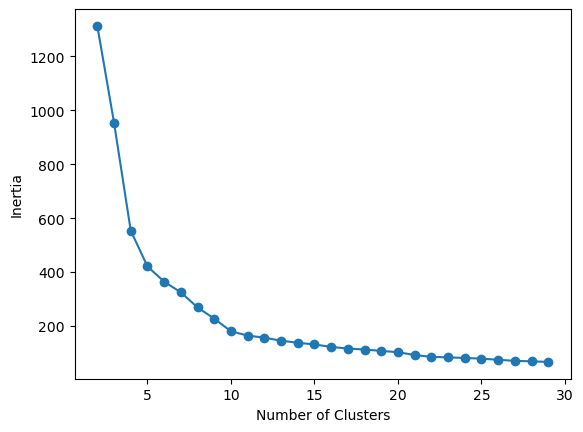

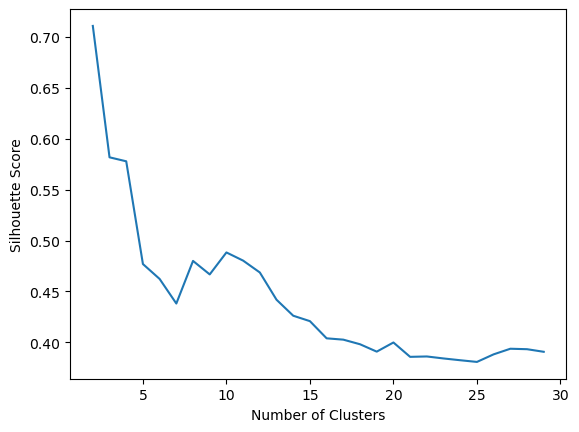

In [16]:
plt.plot(num_clusters, trials, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

plt.plot(num_clusters, sil_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [17]:
optimal_num_clusters = 10
km = KMeans(n_init='auto', 
            n_clusters=optimal_num_clusters, 
            max_iter=1000,
            tol=0.0001,
            random_state=42,
            verbose=1)
km.fit(X)

Initialization complete
Iteration 0, inertia 233.4025219988509.
Iteration 1, inertia 187.7032296711396.
Iteration 2, inertia 183.70284029852454.
Iteration 3, inertia 181.89421157238357.
Iteration 4, inertia 180.98085623593357.
Iteration 5, inertia 180.69277424430013.
Iteration 6, inertia 180.56879281925512.
Converged at iteration 6: center shift 6.119934846836205e-06 within tolerance 7.211864951932415e-06.


KMeans(max_iter=1000, n_clusters=10, n_init='auto', random_state=42, verbose=1)

In [18]:
analyze_clusters(X, km.labels_, gid_codes)

100%|███████████████████████████████████████████| 30000/30000 [00:00<00:00, 67584.55it/s]

Average Features of a given cluster
{0: array([0.05902222, 0.02144733, 0.04681497]),
 1: array([0.        , 0.12409317, 0.10040444]),
 2: array([0.        , 0.08486   , 0.08961955]),
 3: array([0.08896667, 0.00131983, 0.04515849]),
 4: array([0.        , 0.05264567, 0.03670616]),
 5: array([0.03105556, 0.07794867, 0.0529095 ]),
 6: array([0.        , 0.09006083, 0.09530302]),
 7: array([0.0677    , 0.01597067, 0.03484986]),
 8: array([0.05535556, 0.03321333, 0.0432991 ]),
 9: array([0.00561111, 0.00673333, 0.00908835])}

Number of events by the actors in a given cluster
{0: {'CHN': 720, 'RUS': 925, 'USA': 1011},
 1: {'CHN': 1637, 'RUS': 1931, 'USA': 2132},
 2: {'CHN': 1623, 'RUS': 1663, 'USA': 1701},
 3: {'CHN': 692, 'RUS': 996, 'USA': 981},
 4: {'CHN': 745, 'RUS': 733, 'USA': 377},
 5: {'CHN': 1024, 'RUS': 887, 'USA': 884},
 6: {'CHN': 1966, 'RUS': 1071, 'USA': 1274},
 7: {'CHN': 634, 'RUS': 704, 'USA': 693},
 8: {'CHN': 782, 'RUS': 950, 'USA': 759},
 9: {'CHN': 177, 'RUS': 140, 'USA'